1. Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [12]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


2. Read CSV as Dataframe

In [15]:
df = pd.read_csv('data/StudentsPerformance.csv')
df.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


3. Prepare X and Y variables. In this project, we would like to predict the math score of a student given other characteristics i.e. features.

In [16]:
X = df.drop(columns='math score', axis=1)
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [17]:
y = df['math score']
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

4. Showing Unique Values/Categories in each column

In [18]:
for col in X.columns:
    if col not in ['reading score', 'writing score']:
        print('Categories in {0} are {1}'.format(col, df[col].unique()))

Categories in gender are ['female' 'male']
Categories in race/ethnicity are ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in parental level of education are ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in lunch are ['standard' 'free/reduced']
Categories in test preparation course are ['none' 'completed']


5. Now, the next step to *transform* your data, both numeric and categorical.

In [19]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = StandardScaler()
ohe_transformer = OneHotEncoder()

col_transformer = ColumnTransformer(
    [
        ("OneHotEncoder", ohe_transformer, cat_features), 
        ("StandardScalar", num_transformer, num_features)
    ]
)

In [20]:
X = col_transformer.fit_transform(X)
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [21]:
X.shape

(1000, 19)

6. Split the dataset into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (800, 19)
y_train shape: (800,)
X_test shape: (200, 19)
y_test shape: (200,)


7. Create a evaluation function that calculates the values of all metrics.

In [23]:
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

8. Define models

In [24]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "Catboosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoostRegressor": AdaBoostRegressor()
}

9. Train models and evaluate them.

In [25]:
mae_list = []
rmse_list = []
r2_list = []

for key in models.keys():
    current_model = models[key]
    current_model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = current_model.predict(X_train)
    y_test_pred = current_model.predict(X_test)

    # Evaluate model on train and test sets
    train_mae, train_rmse, train_r2 = evaluate(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate(y_test, y_test_pred) 

    print(f'{key} Performance for training set:')
    print(f'- Root Mean Squared Error: {round(train_rmse, 2)}')
    print(f'- Mean Absolute Error: {round(train_mae, 2)}')
    print(f'- R2 Score: {round(train_r2, 2)}')
    print('--------------------------------------------------------')
    print(f'{key} Performance for test set:')
    print(f'- Root Mean Squared Error: {round(test_rmse, 2)}')
    print(f'- Mean Absolute Error: {round(test_mae, 2)}')
    print(f'- R2 Score: {round(test_r2, 2)}')

    mae_list.append(round(test_mae, 2)); rmse_list.append(round(test_rmse, 2)); r2_list.append(round(test_r2, 2))
    print('='*55)

Linear Regression Performance for training set:
- Root Mean Squared Error: 5.33
- Mean Absolute Error: 4.27
- R2 Score: 0.87
--------------------------------------------------------
Linear Regression Performance for test set:
- Root Mean Squared Error: 5.43
- Mean Absolute Error: 4.22
- R2 Score: 0.88
Lasso Performance for training set:
- Root Mean Squared Error: 6.59
- Mean Absolute Error: 5.21
- R2 Score: 0.81
--------------------------------------------------------
Lasso Performance for test set:
- Root Mean Squared Error: 6.52
- Mean Absolute Error: 5.16
- R2 Score: 0.83
Ridge Performance for training set:
- Root Mean Squared Error: 5.32
- Mean Absolute Error: 4.26
- R2 Score: 0.87
--------------------------------------------------------
Ridge Performance for test set:
- Root Mean Squared Error: 5.39
- Mean Absolute Error: 4.21
- R2 Score: 0.88


K-Neighbors Regressor Performance for training set:
- Root Mean Squared Error: 5.71
- Mean Absolute Error: 4.52
- R2 Score: 0.86
--------------------------------------------------------
K-Neighbors Regressor Performance for test set:
- Root Mean Squared Error: 7.25
- Mean Absolute Error: 5.62
- R2 Score: 0.78
Decision Tree Regressor Performance for training set:
- Root Mean Squared Error: 0.28
- Mean Absolute Error: 0.02
- R2 Score: 1.0
--------------------------------------------------------
Decision Tree Regressor Performance for test set:
- Root Mean Squared Error: 8.21
- Mean Absolute Error: 6.59
- R2 Score: 0.72
Random Forest Regressor Performance for training set:
- Root Mean Squared Error: 2.25
- Mean Absolute Error: 1.82
- R2 Score: 0.98
--------------------------------------------------------
Random Forest Regressor Performance for test set:
- Root Mean Squared Error: 5.99
- Mean Absolute Error: 4.63
- R2 Score: 0.85
XGBRegressor Performance for training set:
- Root Mean Squar

10. Show Results

In [26]:
pd.DataFrame(list(zip(list(models.keys()), r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.88
2,Ridge,0.88
5,Random Forest Regressor,0.85
7,Catboosting Regressor,0.85
8,AdaBoostRegressor,0.85
1,Lasso,0.83
6,XGBRegressor,0.83
3,K-Neighbors Regressor,0.78
4,Decision Tree Regressor,0.72


In [27]:
pd.DataFrame(list(zip(list(models.keys()), rmse_list)), columns=[
             'Model Name', 'Root Mean Squared Error']).sort_values(by=["Root Mean Squared Error"], ascending=False)


,Model Name,Root Mean Squared Error
4,Decision Tree Regressor,8.21
3,K-Neighbors Regressor,7.25
1,Lasso,6.52
6,XGBRegressor,6.47
7,Catboosting Regressor,6.01
5,Random Forest Regressor,5.99
8,AdaBoostRegressor,5.96
0,Linear Regression,5.43
2,Ridge,5.39


In [28]:
pd.DataFrame(list(zip(list(models.keys()), mae_list)), columns=[
             'Model Name', 'Mean Absolute Error']).sort_values(by=["Mean Absolute Error"], ascending=False)


,Model Name,Mean Absolute Error
4,Decision Tree Regressor,6.59
3,K-Neighbors Regressor,5.62
1,Lasso,5.16
6,XGBRegressor,5.06
5,Random Forest Regressor,4.63
7,Catboosting Regressor,4.61
8,AdaBoostRegressor,4.56
0,Linear Regression,4.22
2,Ridge,4.21


10. Let us pick Linear Regression as the best performing model.

In [29]:
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)
y_test_pred = linear_reg.predict(X_test)
r2_score_test = r2_score(y_test, y_test_pred)
print(f'Accuracy of Linear Regression is: {round(round(r2_score_test, 2) * 100)}%')

Accuracy of Linear Regression is: 88%


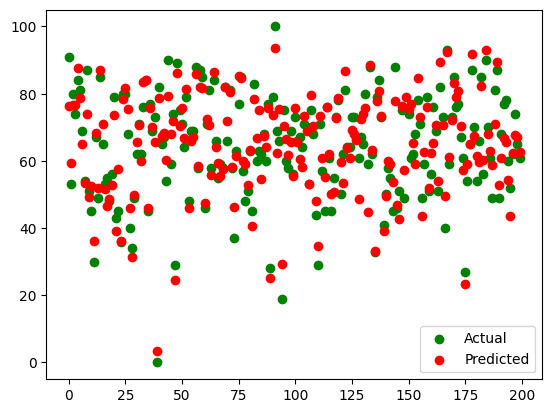

In [30]:
plt.scatter(np.arange(len(y_test)), y_test, color='green', label='Actual')
plt.scatter(np.arange(len(y_test_pred)), y_test_pred, color='red', label='Predicted')
plt.legend()
plt.show()

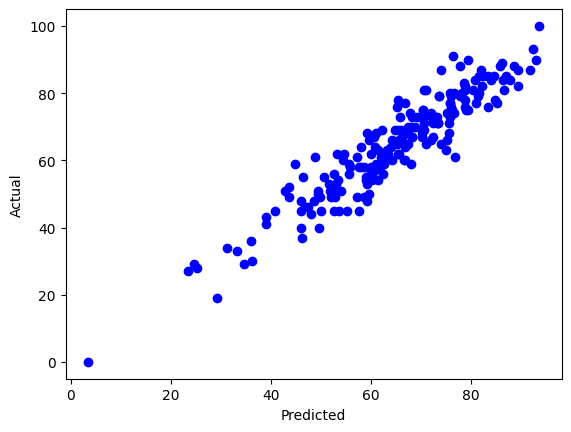

In [31]:
plt.scatter(y_test_pred, y_test, color='blue')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

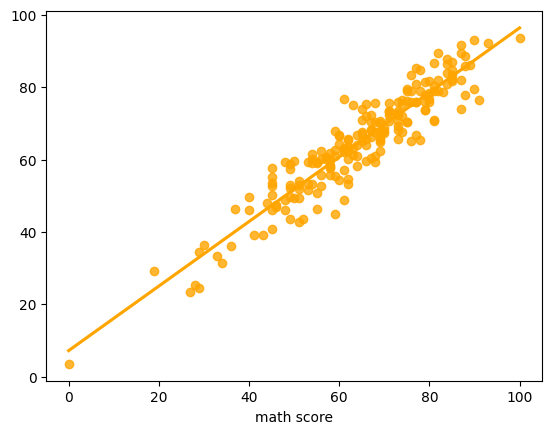

In [32]:
sns.regplot(x=y_test, y=y_test_pred, ci=None, color='orange');

In [33]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Difference': (y_test - y_test_pred)})
pred_df

,Actual,Predicted,Difference
521,91,76.4375,14.5625
737,53,59.3125,-6.3125
740,80,76.6250,3.3750
660,74,76.5625,-2.5625
411,84,87.7500,-3.7500
...,...,...,...
408,52,43.6875,8.3125
332,62,62.3125,-0.3125
208,74,67.7500,6.2500
613,65,67.0000,-2.0000
